In [ ]:
!nvidia-smi

Tue Nov 21 19:44:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/bodybuilder1/train'
test_path = '/content/drive/MyDrive/bodybuilder1/test'
val_path = '/content/drive/MyDrive/bodybuilder1/valid'

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.keras.layers.Input
tf.keras.layers.Lambda
tf.keras.layers.Dense
tf.keras.layers.Flatten
tf.keras.models.Model
from keras.applications.efficientnet import EfficientNetB7
from keras.applications.efficientnet import preprocess_input
tf.keras.preprocessing.image
tf.keras.preprocessing.image.ImageDataGenerator
tf.keras.models.Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import os

import random

import pandas as pd
import seaborn as sns

In [ ]:
class_labels = sorted(os.listdir(train_path))
class_labels

['non_steroid', 'steroid']

In [ ]:
directories = os.listdir(train_path)
image_steroid = []
image_non_steroid = []
class_images = []

for d in directories:
    image_paths = train_path + '/' + d + '/*.jpg'
    image_files = glob(image_paths)
    for i in range(5):
        if d == 'steroid':
            image_steroid.append(plt.imread(image_files[random.randint(0, len(image_files) - 1)]))
        else:
            image_non_steroid.append(plt.imread(image_files[random.randint(0, len(image_files) - 1)]))
    class_images.append(image_files)

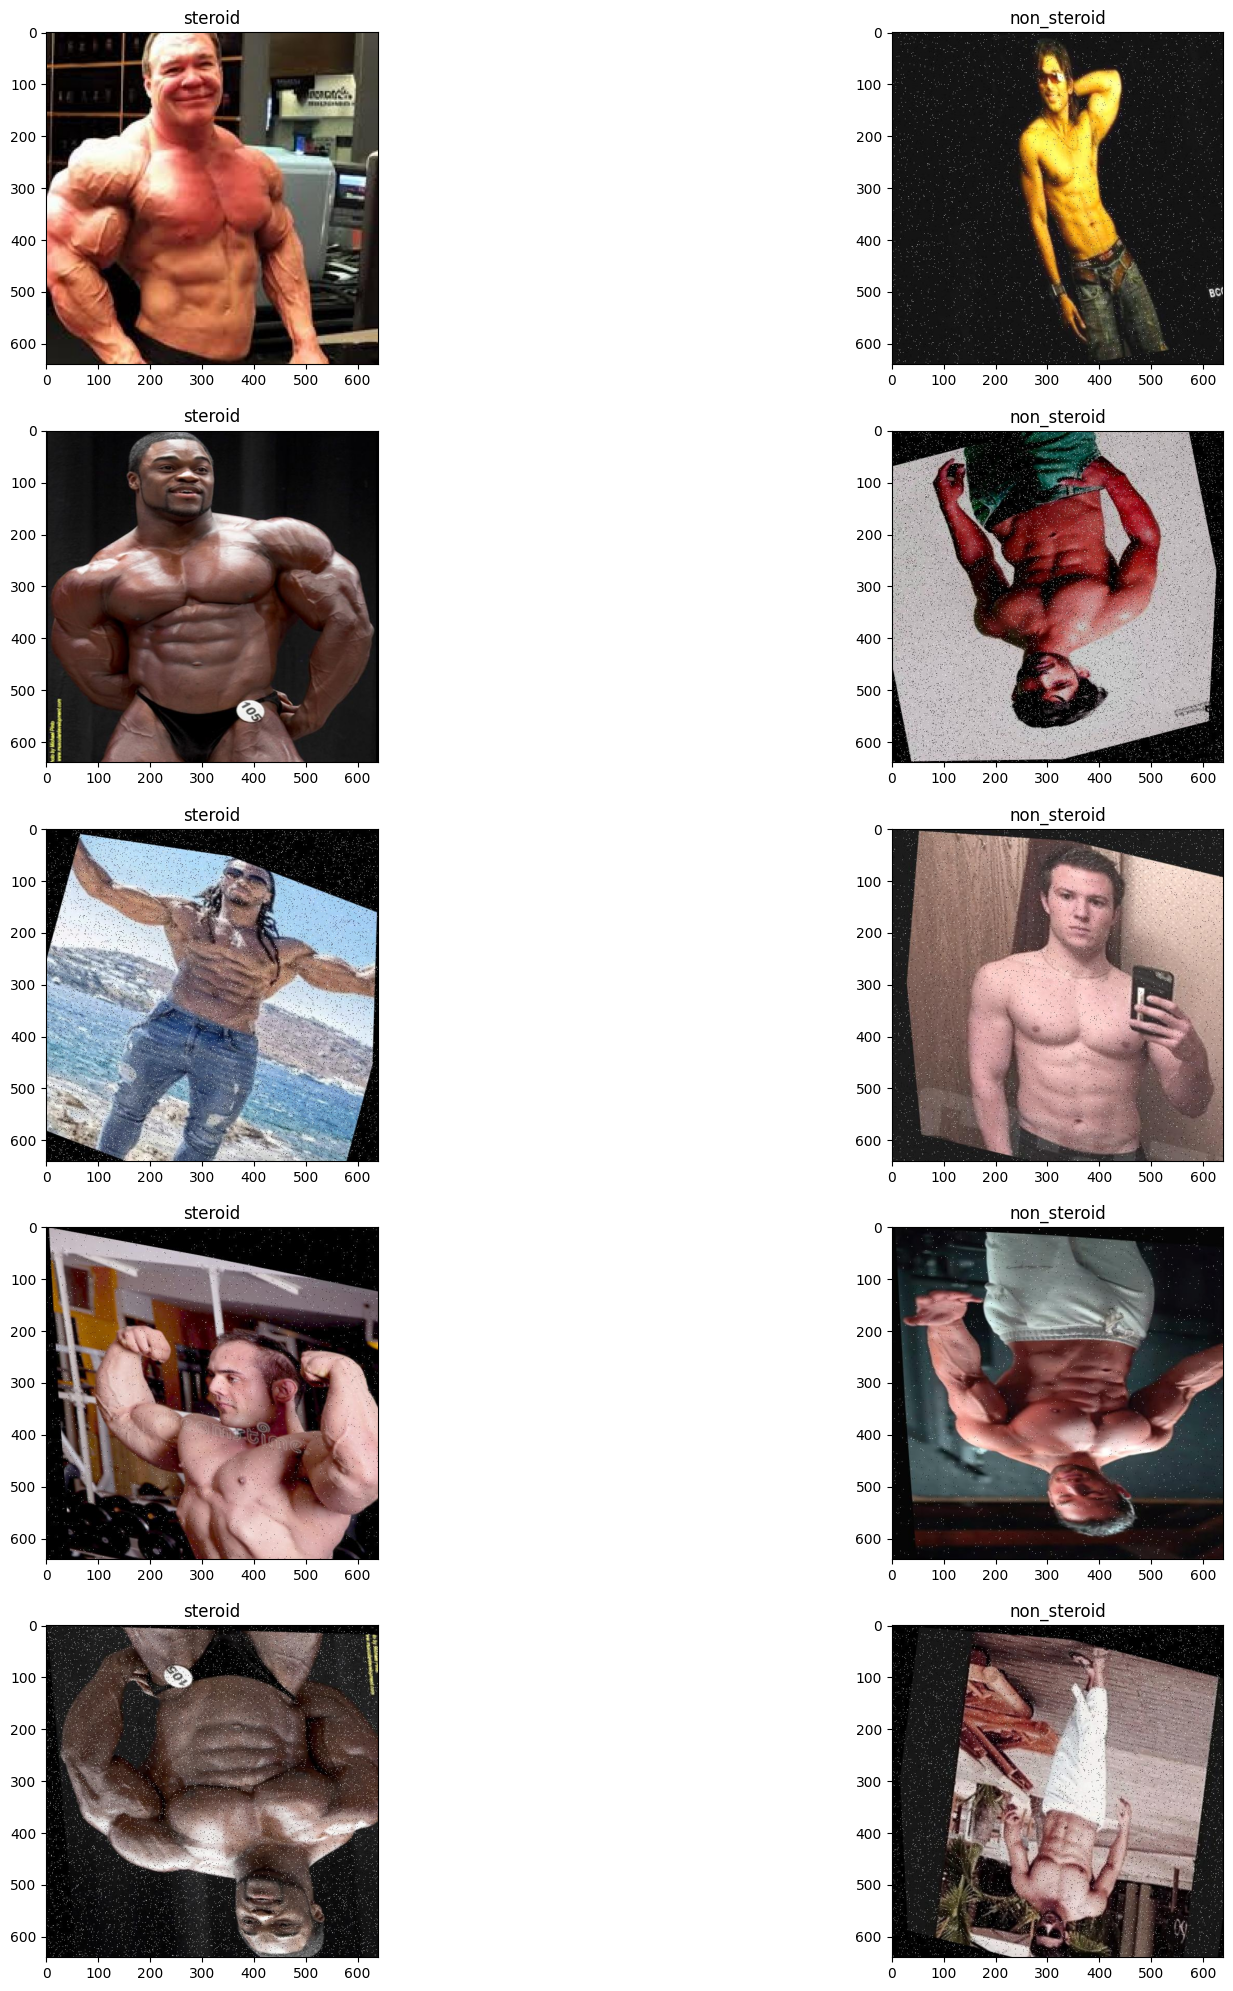

In [ ]:
plt.figure(figsize=(20,25))

count = 0
offset = 1

while count < len(image_steroid):
    plt.subplot(5,2,count+offset)
    # image = batch[0]
    plt.imshow(np.squeeze(image_steroid[count]))
    plt.title('steroid')
    plt.subplot(5,2,count+offset+1)
    # image = batch[0]
    plt.imshow(np.squeeze(image_non_steroid[count]))
    plt.title('non_steroid')

    count += 1
    offset += 1

In [ ]:
train_image_count = []

for i in class_images:
    train_image_count.append(len(i))

train_image_count

[1565, 1549]

In [ ]:
directories = os.listdir(test_path)
test_image_count = []

for d in directories:
    image_paths = test_path + '/' + d + r'/*.jpg'
    image_files = glob(image_paths)
    test_image_count.append(len(image_files))

test_image_count

[392, 279]

In [ ]:
directories = os.listdir(val_path)
val_image_count = []

for d in directories:
    image_paths = val_path + '/' + d + r'/*.jpg'
    image_files = glob(image_paths)
    val_image_count.append(len(image_files))

val_image_count

[257, 297]

In [ ]:
dataset_info = pd.DataFrame({'Label': class_labels, 'Train_Count': train_image_count, 'Test_Count': test_image_count, 'Val_Count': val_image_count})
dataset_info

Label  Train_Count  Test_Count  Val_Count
0  non_steroid         1565         392        257
1      steroid         1549         279        297

In [ ]:
df = pd.melt(dataset_info, id_vars='Label', var_name='Split', value_name="Count")
df

Label        Split  Count
0  non_steroid  Train_Count   1565
1      steroid  Train_Count   1549
2  non_steroid   Test_Count    392
3      steroid   Test_Count    279
4  non_steroid    Val_Count    257
5      steroid    Val_Count    297

<Figure size 2000x800 with 0 Axes>

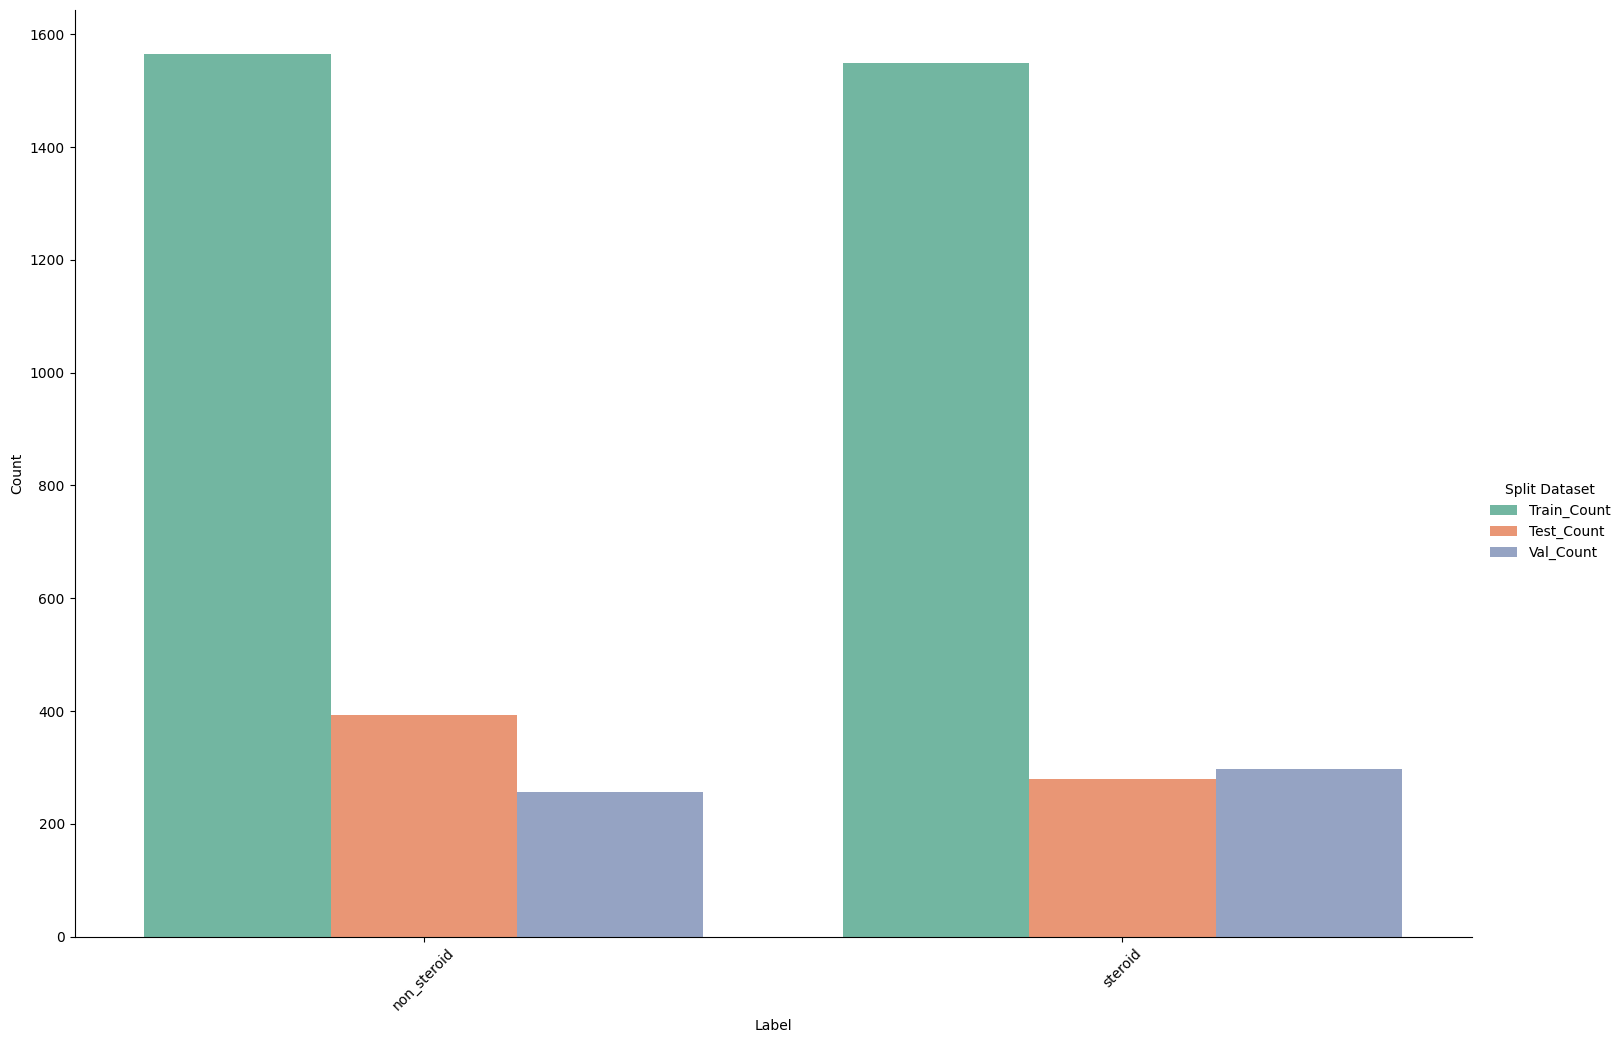

In [ ]:
plt.figure(figsize=(20, 8))

g = sns.catplot(
    data=df, kind='bar',
    x='Label', y='Count', hue='Split', palette='Set2', height=10, aspect=1.5)

plt.xticks(rotation=45)
g.set_axis_labels('Label', 'Count')
g.legend.set_title('Split Dataset')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(val_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3114 files belonging to 2 classes.
Found 554 files belonging to 2 classes.
Found 671 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

258076736/258076736 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 244, 244, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 244, 244, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 244, 244, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 244, 244, 3)          0         ['normalization[0

In [ ]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

18/18 [==============================] - 131s 3s/step - loss: 0.7008 - accuracy: 0.5325
initial loss: 0.70
initial accuracy: 0.53


In [ ]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset)

Epoch 1/30


ResourceExhaustedError: ignored

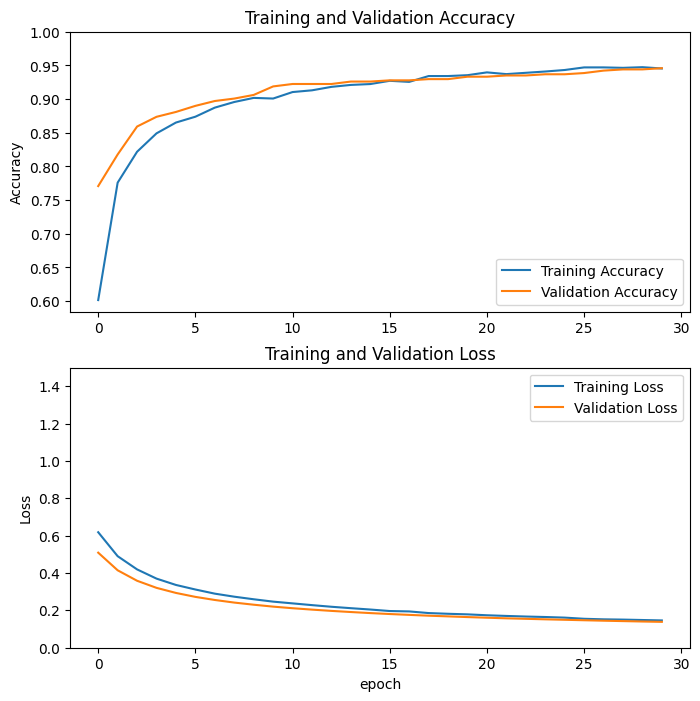

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
for layer in base_model.layers:
  layer.trainable = True

Number of layers in the base model:  814


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/100),
              metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
loss= model.evaluate(test_dataset)
accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

21/21 [==============================] - 10s 437ms/step - loss: 0.1144 - accuracy: 0.9672 - precision: 0.9793 - recall: 0.9643
Test accuracy : [0.11435534805059433, 0.9672130942344666, 0.9792746305465698, 0.9642857313156128]


Predictions:
 [1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1]
Labels:
 [1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1]


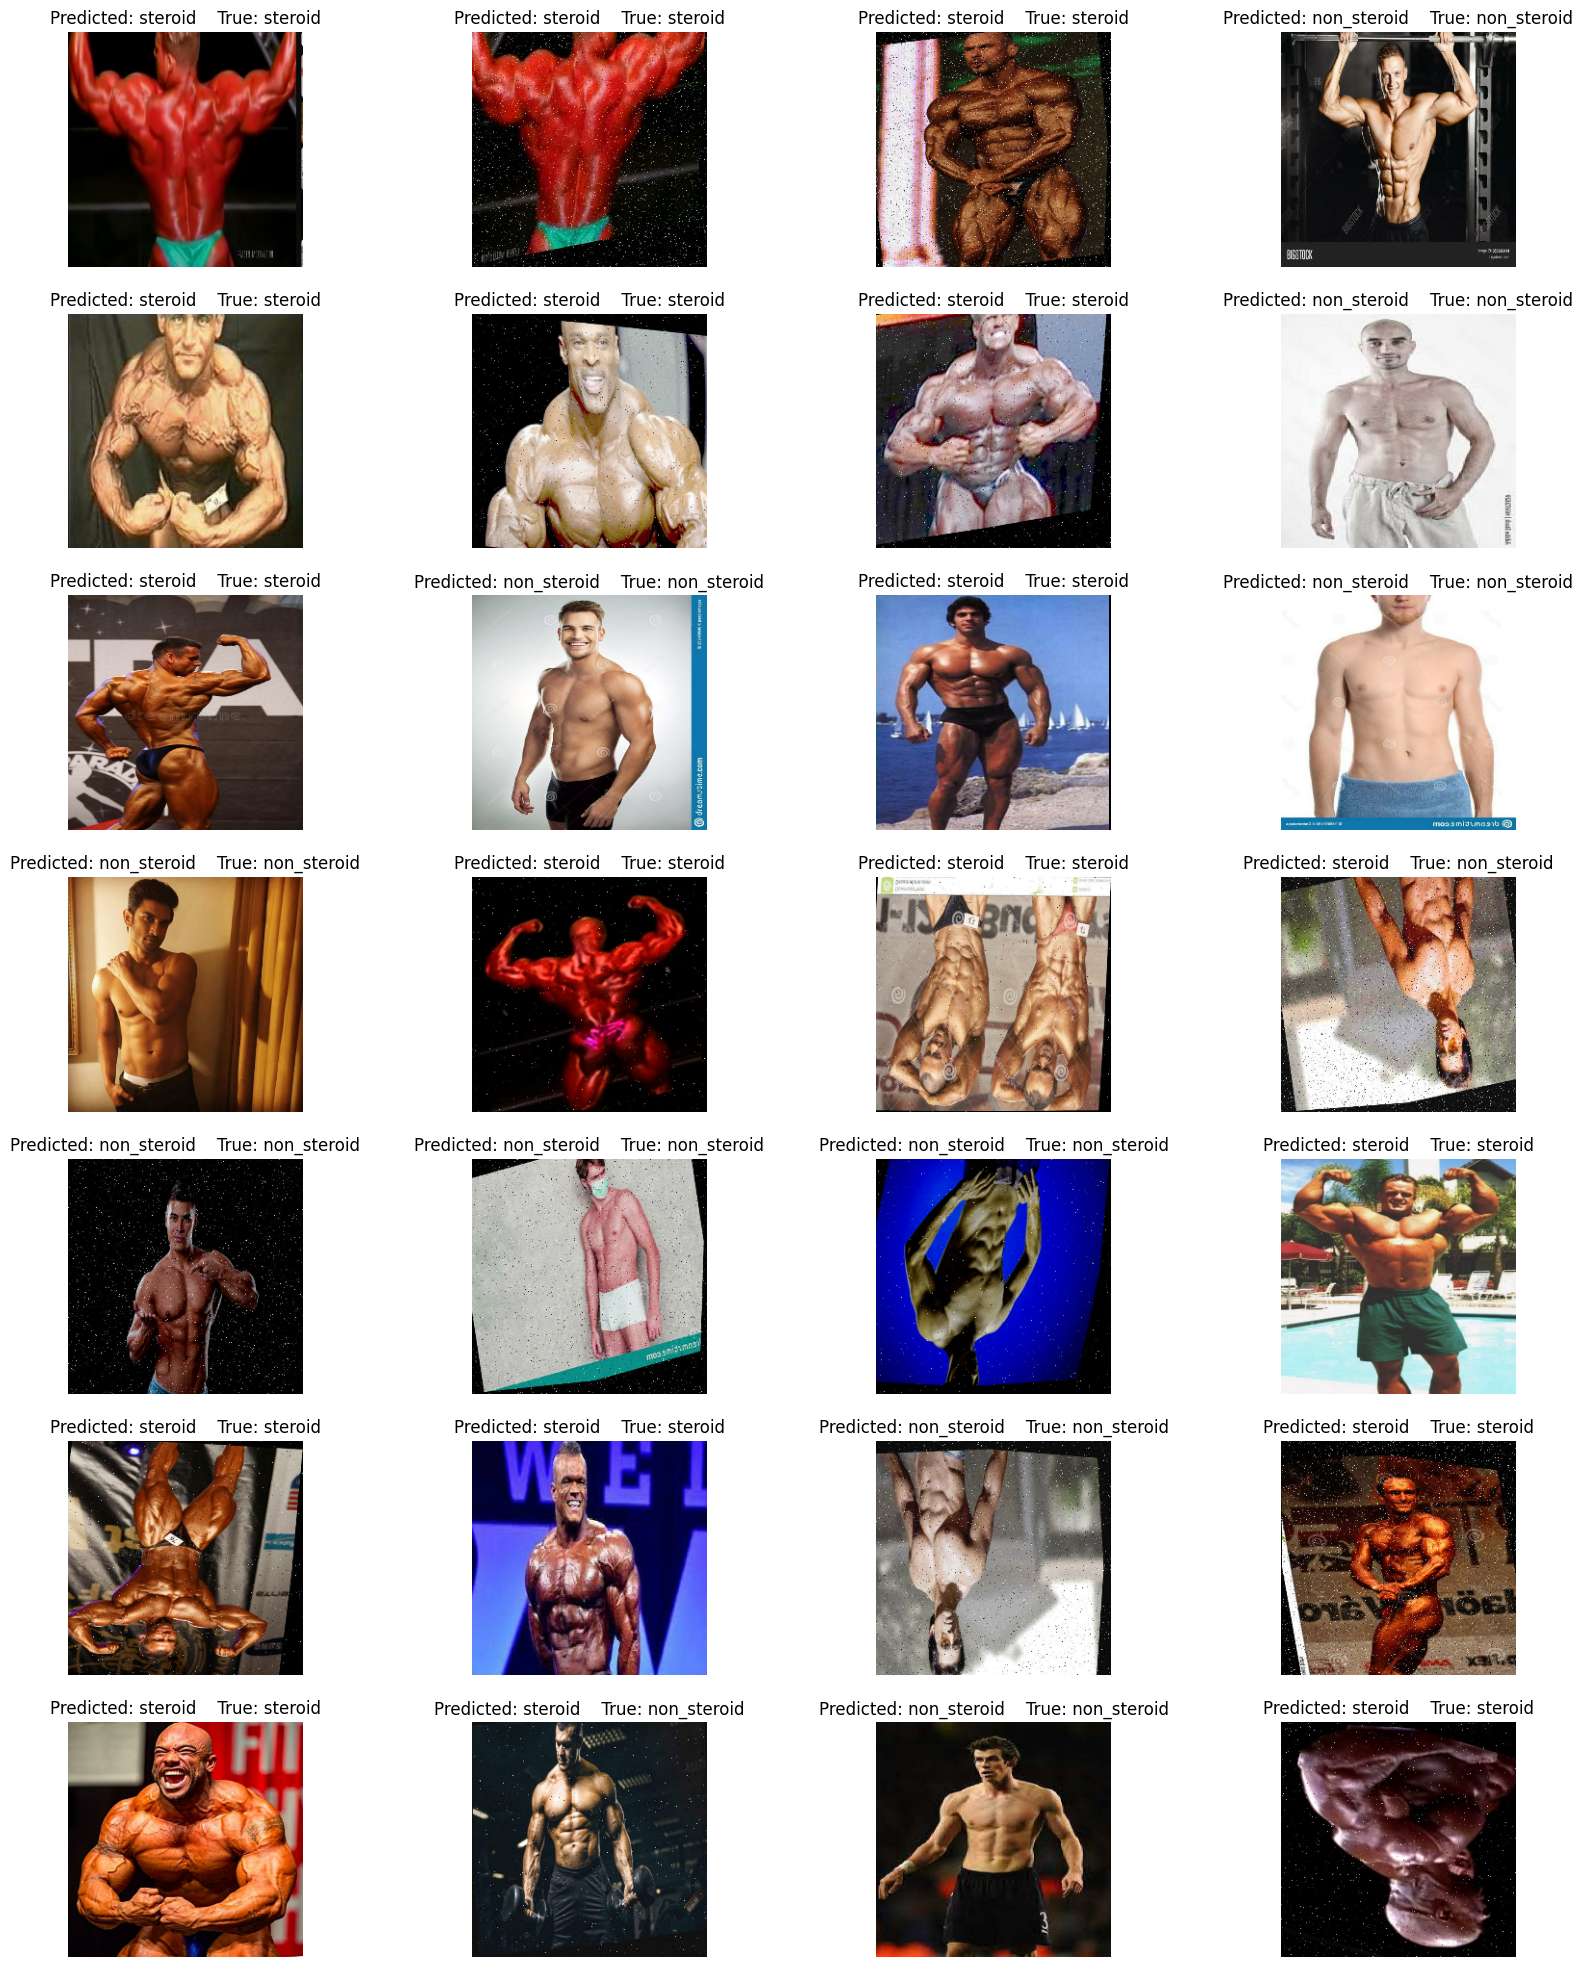

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 25))
for i in range(28):
  ax = plt.subplot(7, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('Predicted: '+ class_names[predictions[i]] + '    True: ' + class_names[label_batch[i]])
  plt.axis("off")

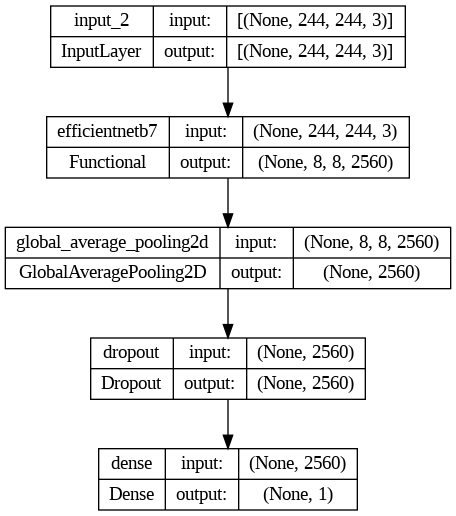

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [ ]:
model.save('buildEfficientB7Final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predict = np.array([])
l =  np.array([])
for x, y in test_dataset:
  p = model.predict(x).flatten()
  p = tf.nn.sigmoid(p)
  p = tf.where(p < 0.5, 0, 1)
  predict = np.concatenate([predict, p])
  l = np.concatenate([l, y])

1/1 [==============================] - 0s 369ms/step


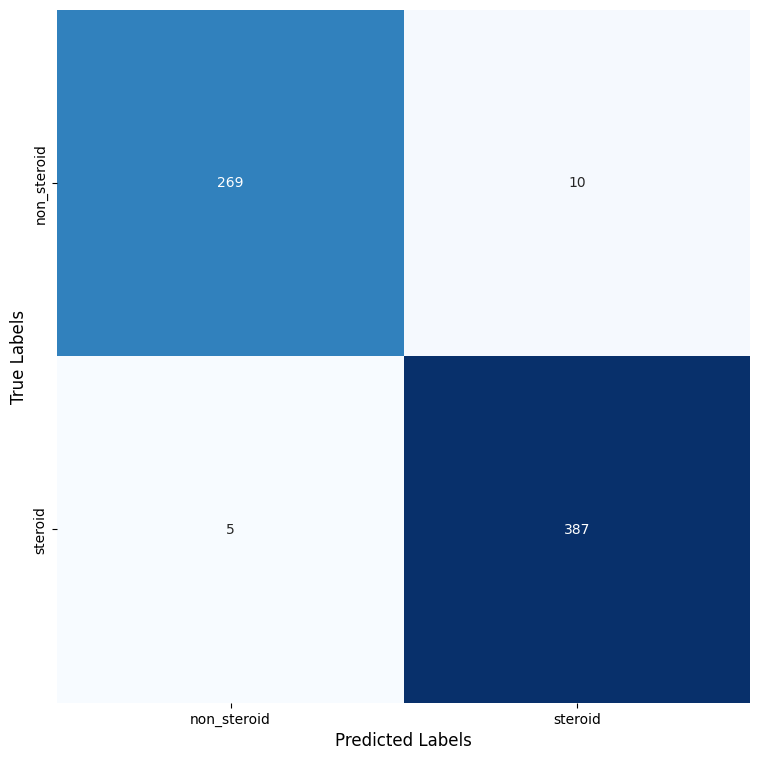

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(l, predict)

plt.figure(figsize=(10,9))
sns.heatmap(cm, annot=True, square=True, xticklabels=class_names, yticklabels=class_names, fmt='d',
           cmap=plt.cm.Blues, cbar=False)
plt.ylabel('True Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Classification Report
report = classification_report(l, predict, target_names=class_names)
print(report)

              precision    recall  f1-score   support

 non_steroid       0.98      0.96      0.97       279
     steroid       0.97      0.99      0.98       392

    accuracy                           0.98       671
   macro avg       0.98      0.98      0.98       671
weighted avg       0.98      0.98      0.98       671

